In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

Read the prices data for 7 stocks from the download csv file.
Calculate the daily returns and plot.

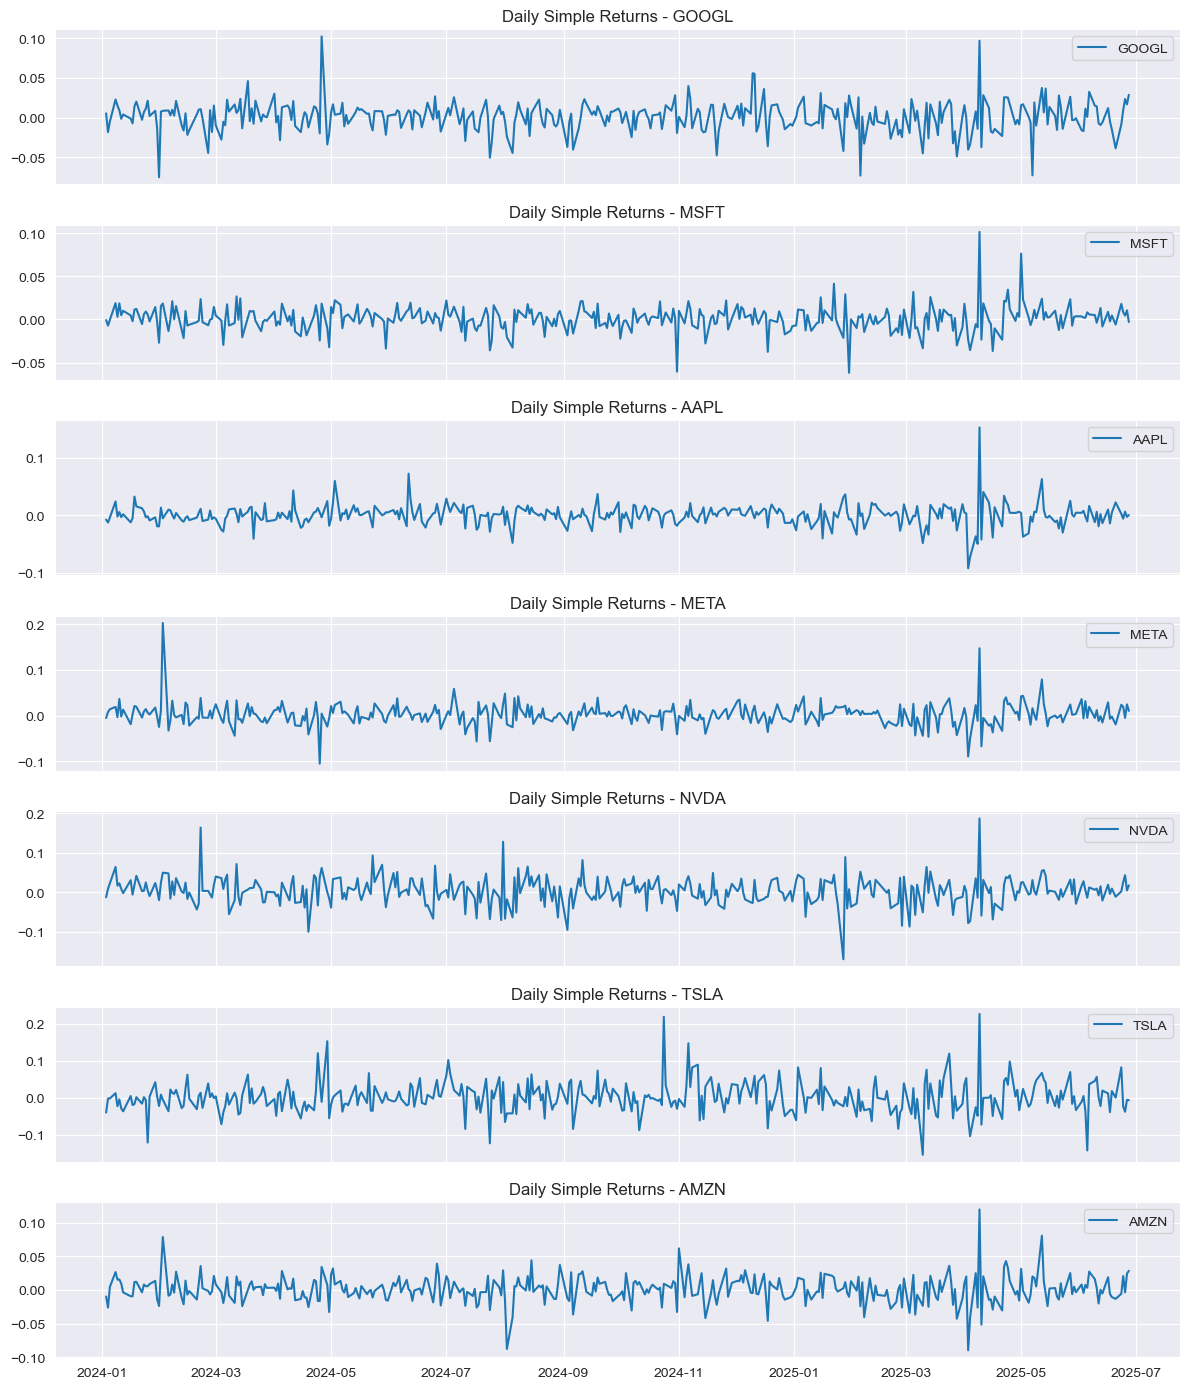

In [2]:
prices = pd.read_csv('prices.csv', index_col=0, parse_dates=True)
returns = prices / prices.shift(1) - 1
returns = returns.dropna()

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(12, 14), sharex=True)

for i, col in enumerate(returns.columns):
    axes[i].plot(returns.index, returns[col], label=col, color="tab:blue")
    axes[i].set_title(f"Daily Simple Returns - {col}")
    axes[i].grid(True)
    axes[i].legend(loc="upper right")

plt.tight_layout()
plt.show()

Calculate the correlation matrix and plot to visualize the stock movement correlations.

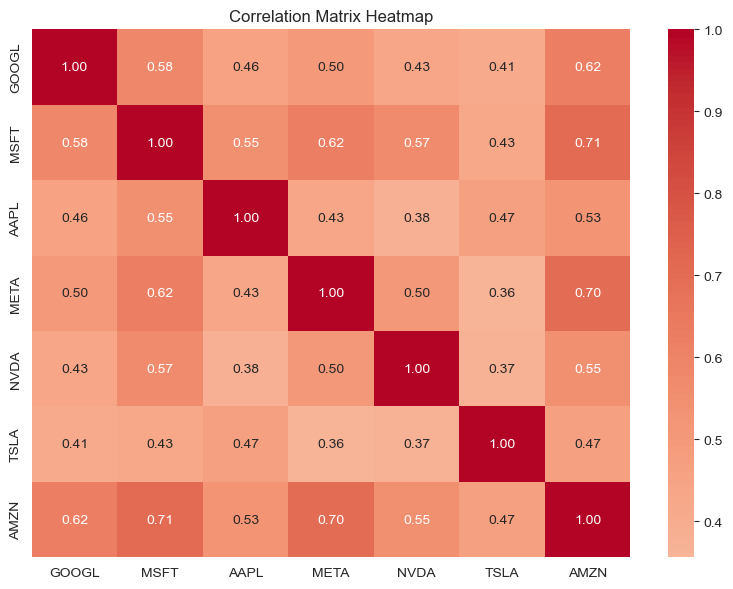

In [3]:
corr_matrix = returns.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

Calculate the PCA based on correlation matrix and show the strength of eigenvalues.
Plot the eigenvectors to show the co-movement pattens of 7 stocks.

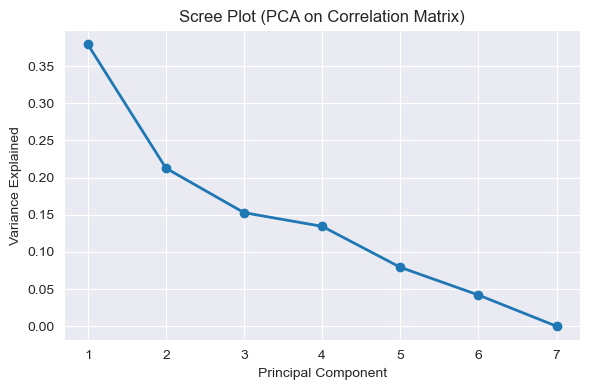

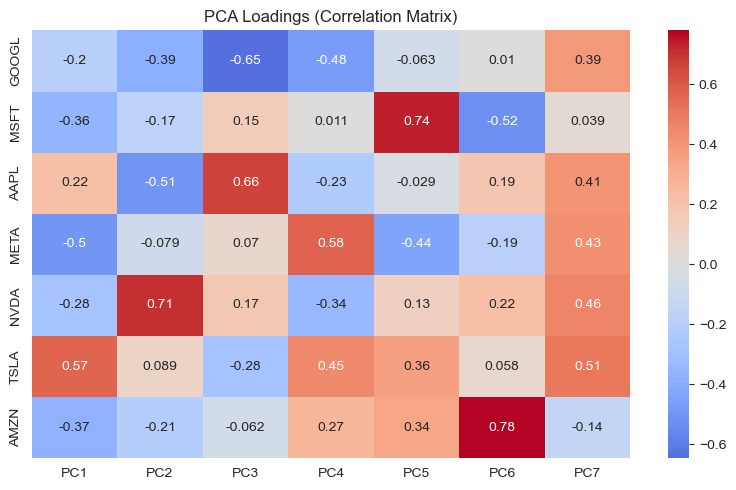

In [4]:
pca = PCA(n_components=corr_matrix.shape[0])
pca.fit(corr_matrix)

explained_var = pca.explained_variance_ratio_
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_var) + 1), explained_var, 'o-', linewidth=2)
plt.title("Scree Plot (PCA on Correlation Matrix)")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.grid(True)
plt.tight_layout()
plt.show()

loadings = pd.DataFrame(pca.components_.T,
                        index=corr_matrix.columns,
                        columns=[f"PC{i+1}" for i in range(len(explained_var))])

plt.figure(figsize=(8, 5))
sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0)
plt.title("PCA Loadings (Correlation Matrix)")
plt.tight_layout()
plt.show()

Use the last day alpha via '-returns' as an example.
Project the alpha to the PC1 or PC1 & PC2.
Plot the raw alpha, projected contribution and residues. Take the residues as the remaining alpha after Statistical Neutralization.

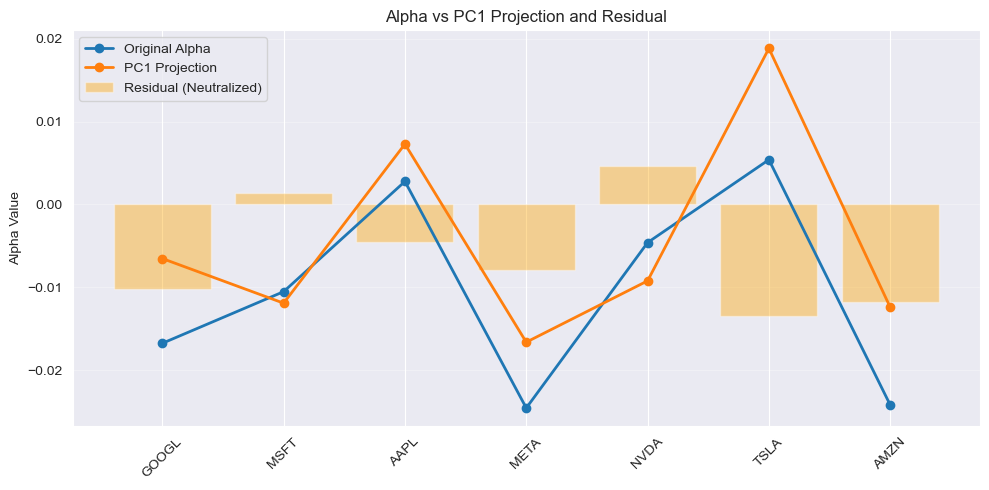

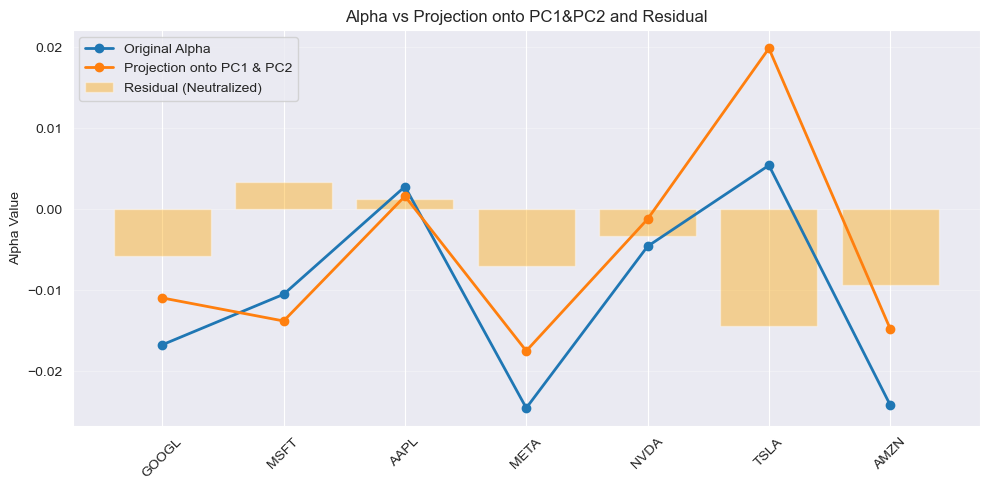

In [5]:
PC1 = pca.components_[0, :]   # shape: (n_stocks, )
cols = corr_matrix.columns.tolist()
alpha_lastday = -returns.iloc[-2, :].values  # second-last day so no NaN
exposure_pc1 = np.dot(alpha_lastday, PC1)
alpha_proj_pc1 = exposure_pc1 * PC1
alpha_residual = alpha_lastday - alpha_proj_pc1  # neutralized vs PC1

x = np.arange(len(cols))
plt.figure(figsize=(10, 5))
plt.plot(x, alpha_lastday, marker='o', label="Original Alpha", linewidth=2)
plt.plot(x, alpha_proj_pc1, marker='o', label="PC1 Projection", linewidth=2)
plt.bar(x, alpha_residual, alpha=0.4, label="Residual (Neutralized)", color='orange')

plt.xticks(x, cols, rotation=45)
plt.ylabel("Alpha Value")
plt.title("Alpha vs PC1 Projection and Residual")
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# statistical neutralizing on PC1&PC2
V = pca.components_[0:2, :].T   # shape: N x 2  (columns are PC1, PC2)
cols = corr_matrix.columns.tolist()

# Alpha = previous day's negative return
alpha_lastday = -returns.iloc[-2, :].values

# Projection onto PC1 & PC2 together
projection = V @ (V.T @ alpha_lastday)   # N vector

# Residual (neutralized alpha)
alpha_residual = alpha_lastday - projection

# Plot: Original, Projection, Residual
x = np.arange(len(cols))
plt.figure(figsize=(10, 5))
plt.plot(x, alpha_lastday, marker='o', label="Original Alpha", linewidth=2)
plt.plot(x, projection, marker='o', label="Projection onto PC1 & PC2", linewidth=2)
plt.bar(x, alpha_residual, alpha=0.4, label="Residual (Neutralized)", color='orange')

plt.xticks(x, cols, rotation=45)
plt.ylabel("Alpha Value")
plt.title("Alpha vs Projection onto PC1&PC2 and Residual")
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()